# ch04.08 Transformer

* 날짜: 2022-09-06
* 이름: 고민수

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [3]:
from lib_tf import *
from tensorflow.keras import layers, models

Hangul OK in your window!


## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [2]:
h = 8
d_k = 64
d_v = 64
d_model = 64 * h # 512 #embedding dims

# input * shape
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max length, vocab size )
# 텍스트 임베딩 : ( max length, embedding dims )
T = 200
S = 100

# -> (V, K, Q)
Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)

print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [11]:
def matmul(shape1, shape2):
    assert shape1[1] == shape2[0]
    return (shape1[0], shape2[1])
A = (100,300)
B = (300,200)
matmul(A,B)

(100, 200)

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [12]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v)
# calculate shape
VW = matmul(V, W_V)
KW = matmul(K, W_K)
QW = matmul(Q, W_Q)

print(f'Q {Q} x W_Q  {W_Q} = {QW}')
print(f'K {K} x W_K  {W_K} = {KW}')
print(f'V {V} x W_V  {W_V} = {VW}')

Q (200, 512) x W_Q  (512, 64) = (200, 64)
K (100, 512) x W_K  (512, 64) = (100, 64)
V (100, 512) x W_V  (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [13]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW)
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [16]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) = {concat_att}')

W_O = ( (h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) = (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output (200, 512)


In [ ]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [25]:
h = 8
d_k = 64
d_v = 64
d_model = 64 * h  # 512

T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
###

Q = tf.keras.layers.Input(shape=(T, d_model))
V = tf.keras.layers.Input(shape=(S, d_model))
K = tf.keras.layers.Input(shape=(S, d_model))

y = tf.keras.layers.MultiHeadAttention(
    num_heads=h,
    key_dim=d_k,
    value_dim=d_v,  # d_k = d_v일 때는 적지 않아도 된다.
)(Q, V, K)

In [26]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

- 인풋: V (None, 100, 512) K (None, 100, 512) Q (None, 200, 512)
- 최종 아웃풋: (None, 200, 512)


### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [3]:
def encoder_block(Input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    Inputs = tf.keras.layers.Input(shape=Input_shape)
    # Attention and Normalization
    # multi-head
    y = tf.keras.layers.MultiHeadAttention(num_heads=h,
                                           key_dim=d_k,
                                           dropout=dropout)(Inputs, Inputs)
    y = tf.keras.layers.Dropout(dropout)(y)
    # Add & Norm
    y = tf.keras.layers.LayerNormalization()(y)
    y_1 = tf.keras.layers.Add()([y, Inputs])
    # Feed Forward Part
    ## FF
    y = tf.keras.layers.Conv1D(filters=d_ff,
                               kernel_size=1,
                               activation="leaky_relu")(y_1)
    y = tf.keras.layers.Dropout(dropout)(y)
    y = tf.keras.layers.Conv1D(filters=Inputs.shape[-1],
                               kernel_size=1,
                               activation="leaky_relu")(y)
    ## Add & Norm
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = tf.keras.layers.Add()([y, y_1])
    return tf.keras.models.Model(Inputs, outputs, name=name)

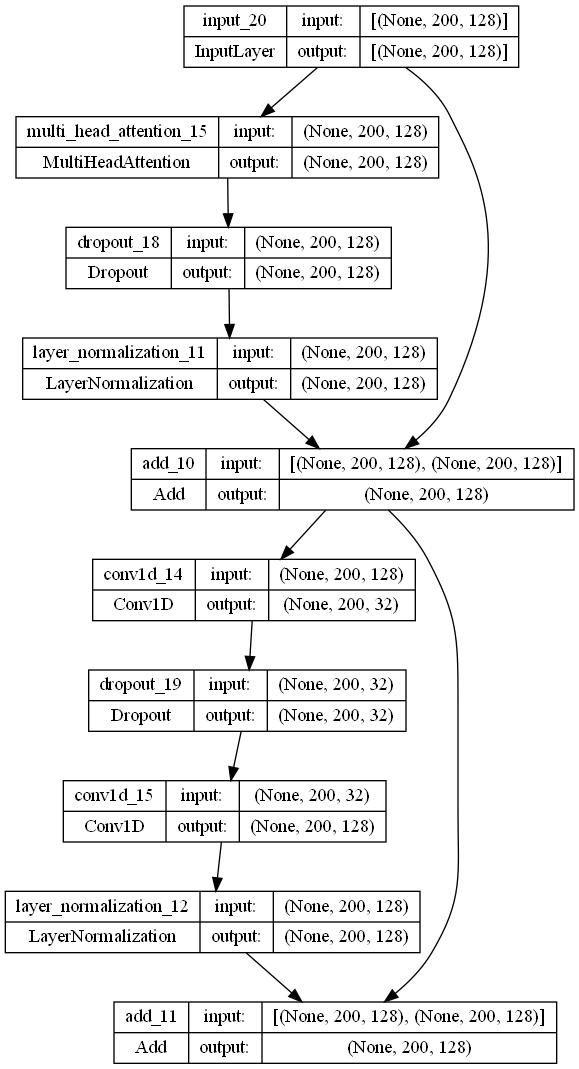

In [45]:
inputs_shape = (200, 128)
h = 8
d_k = 64
d_ff = 32

encoder= encoder_block(inputs_shape, h, d_k, d_ff)
tf.keras.utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [46]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [47]:
import matplotlib.pyplot as plt

(3601, 500, 1) (3601,)


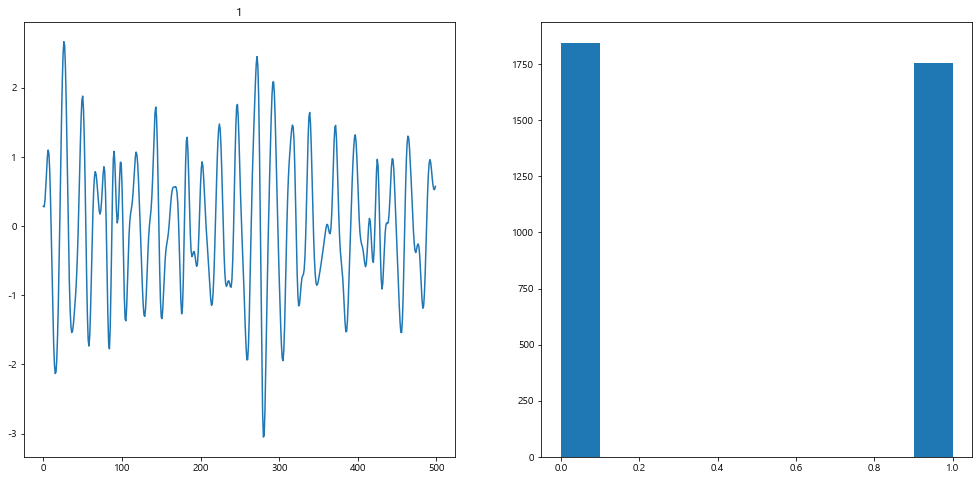

In [52]:
print(x_train.shape, y_train.shape)
idx = 10
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [64]:
# Set params
input_shape = (500, 1)  # (T/s, d_model)
n_classes = 2
h = 4
N = 4
d_k = 128
d_ff = 4

# Set Input
inputs = tf.keras.layers.Input(shape=input_shape)

y = inputs
# Encoder Block
for i in range(N):
    encoder = encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None)
    y = encoder(y)
# Classifier
y = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(y)
y = tf.keras.layers.Dense(128, activation="leaky_relu",)(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(n_classes, activation="softmax")(y)
# Final model
model = tf.keras.models.Model(inputs, y, name="TransformerEncoder")
model.summary()

Model: "TransformerEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 model_36 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_37 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_38 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_39 (Functional)       (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d_5   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                

In [66]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001),metrics="acc")
es = tf.keras.callbacks.EarlyStopping(monitor="val_acc",patience=8, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=[x_test, y_test], batch_size=32, epochs=50, callbacks=[es])

Epoch 1/50
113/113 [==============================] - 17s 127ms/step - loss: 1.1015 - acc: 0.4957 - val_loss: 0.7201 - val_acc: 0.5530
Epoch 2/50
113/113 [==============================] - 14s 123ms/step - loss: 0.9093 - acc: 0.5585 - val_loss: 0.6668 - val_acc: 0.6091
Epoch 3/50
113/113 [==============================] - 14s 124ms/step - loss: 0.8573 - acc: 0.5779 - val_loss: 0.6377 - val_acc: 0.6455
Epoch 4/50
113/113 [==============================] - 14s 123ms/step - loss: 0.7897 - acc: 0.6015 - val_loss: 0.6114 - val_acc: 0.6697
Epoch 5/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7578 - acc: 0.6226 - val_loss: 0.5972 - val_acc: 0.6833
Epoch 6/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7148 - acc: 0.6384 - val_loss: 0.5813 - val_acc: 0.6939
Epoch 7/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7022 - acc: 0.6490 - val_loss: 0.5711 - val_acc: 0.7076
Epoch 8/50
113/113 [==============================] - 1

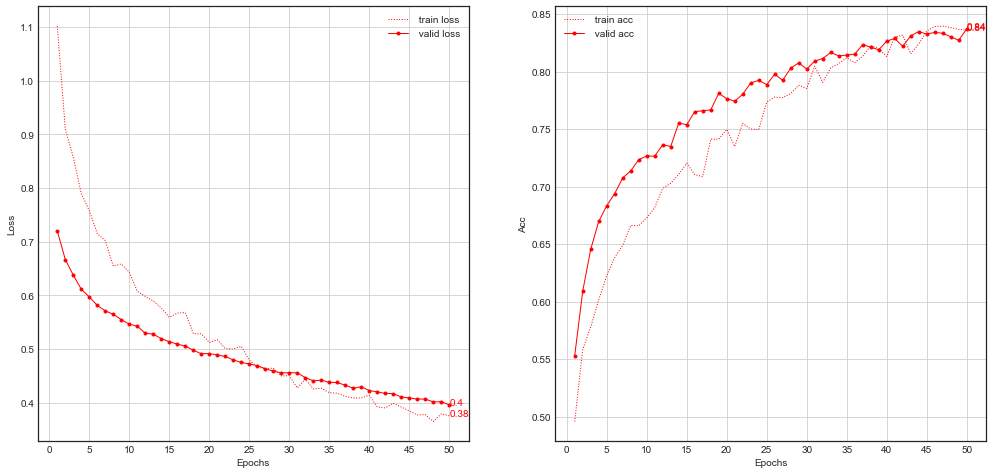

In [71]:
from Myfunc import show_lcurve
history = model.history
show_lcurve([history], [""], size=(17,8), x_itv=5)

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [4]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

25000 Training sequences
25000 Validation sequences
(25000, 200) (25000, 200)


In [6]:
embed_dim = 128

x = tf.keras.layers.Input(shape=(maxlen,))
x_em = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(x)
print(x.shape, x_em.shape)

(None, 200) (None, 200, 128)


In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [12]:
x_embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(x)
print(x_embed.shape)

(None, 200, 128)



### **| 모델 구현**

In [13]:
# Set params
maxlen = 200
vocab_size = 20000
embed_dim = 32
n_classes = 2

h = 4
N = 4
d_k = 32
d_ff = 32

# Set Input
inputs = tf.keras.layers.Input(shape=(maxlen, ))

y_emb = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
# Encoder Bloc

y = y_emb

for i in range(N):
    encoder = encoder_block(y.shape[1:], h, d_k, d_ff, name=f"encoder_{i}")
    y = encoder(y)
# Classifier
y = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(y)
y = tf.keras.layers.Dense(128, activation="leaky_relu",)(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(n_classes, activation="softmax")(y)
# Final model
model = tf.keras.models.Model(inputs, y, name="TransformerEncoder")
model.summary()

(None, 200, 32)
Model: "TransformerEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_0 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_1 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_2 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_3 (Functional)      (No

### **| 학습**

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001),metrics="acc")
es = tf.keras.callbacks.EarlyStopping(monitor="val_acc",patience=8, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=32, epochs=50, callbacks=[es])

Epoch 1/50
782/782 [==============================] - 34s 34ms/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6929 - val_acc: 0.5044
Epoch 2/50
782/782 [==============================] - 26s 34ms/step - loss: 0.6907 - acc: 0.5395 - val_loss: 0.6893 - val_acc: 0.5468
Epoch 3/50
782/782 [==============================] - 26s 33ms/step - loss: 0.5056 - acc: 0.7431 - val_loss: 0.3398 - val_acc: 0.8594
Epoch 4/50
782/782 [==============================] - 26s 34ms/step - loss: 0.2510 - acc: 0.8996 - val_loss: 0.3226 - val_acc: 0.8694
Epoch 5/50
782/782 [==============================] - 26s 33ms/step - loss: 0.1785 - acc: 0.9333 - val_loss: 0.3638 - val_acc: 0.8670
Epoch 6/50
782/782 [==============================] - 26s 34ms/step - loss: 0.1386 - acc: 0.9522 - val_loss: 0.4025 - val_acc: 0.8684
Epoch 7/50
782/782 [==============================] - 27s 34ms/step - loss: 0.1045 - acc: 0.9650 - val_loss: 0.5814 - val_acc: 0.8422
Epoch 8/50
782/782 [==============================] - 26s 34ms

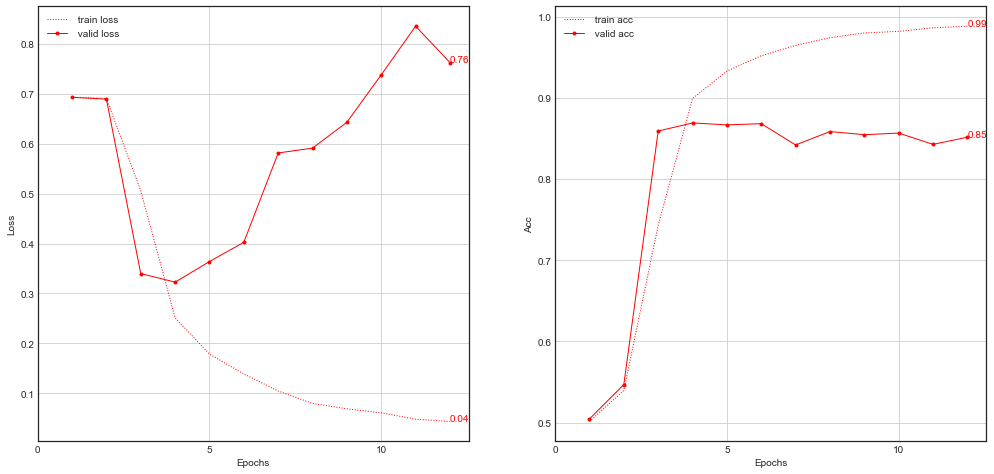

In [16]:
from Myfunc import show_lcurve
history = model.history
show_lcurve([history], [""], size=(17,8), x_itv=5)

## 실습3. Vision Transformer
---

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data() # 100 개의 클래스 
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [1]:
def display_img_patches(img, patches=None):

    # origin image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if patches is not None:
        n = int(np.sqrt(patches.shape[0]))
        patch_size = int(img.shape[0] / n)

        # patch imgs
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
            plt.imshow(patch_img.numpy().astype("uint8"))
            plt.axis("off")
        plt.show()

        # patches
        plt.figure(figsize=(10, 2))
        for i, patch in enumerate(patches):
            ax = plt.subplot(1, n * n, i + 1)
            patch = tf.expand_dims(patch, 1)
            plt.imshow(patch.numpy().astype("uint8"))
            plt.axis("off")
        plt.show()

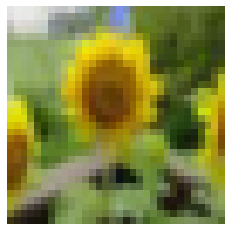

In [6]:
import matplotlib.pyplot as plt
idx = 12
display_img_patches(x_train[idx])

### **| 이미지 증강**

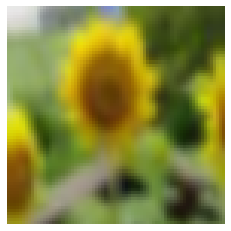

((32, 32, 3), TensorShape([72, 72, 3]))

In [7]:
def aug_model(resize=72):
    # 전처리
    aug_layers = [
        layers.Normalization(),  # 정규화 1/255
        layers.Resizing(resize, resize),  # 리사이즈 
        # 증강
        layers.RandomFlip(mode='horizontal'),  # 랜덤플립
        layers.RandomRotation(factor=0.02),  # 랜덤 회전
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ]  # 랜덤 확대

    model = tf.keras.Sequential(aug_layers, name='ImgAug')
    return model


# train / valid / test : train set에만 자동적으로 증강 레이어가 적용

x_img = x_train[idx]
x_aug = aug_model()(x_img)

display_img_patches(x_aug.numpy().astype('uint8'))
x_img.shape, x_aug.shape

### **| Patch 생성**

In [8]:
class MakePatchLayer(layers.Layer):

    def __init__(self, patch_size):
        super(MakePatchLayer, self).__init__()
        self.patch_size = patch_size

    def call(self, imgs):  # (batch, h, w, ch)
        x_patches = tf.image.extract_patches(
            images=imgs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID')
        # (batch_size, Hpatch개수 , Wpatch개수, patch 차원((patchsize**2)*3 ) )
        batch_size = tf.shape(x_patches)[0]
        d_patches = tf.shape(x_patches)[-1]

        x_patches = tf.reshape(x_patches, [batch_size, -1, d_patches])
        # (batch_size, patch 개수, patch 차원)
        return x_patches

In [12]:
x_aug = tf.expand_dims(x_aug, 0)

(1, 72, 72, 3) (1, 36, 432)


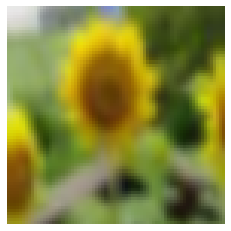

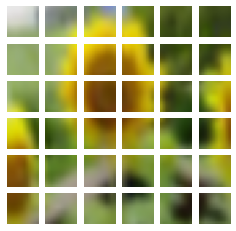

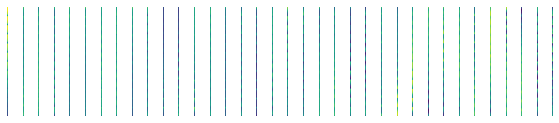

In [13]:
x_patches = MakePatchLayer(12)(x_aug)
print(x_aug.shape, x_patches.shape)
display_img_patches(x_aug[0].numpy().astype('uint8'), x_patches[0])

### **| Patch Encoder**

In [14]:
project_dim = 128
num_patches = tf.shape(x_patches)[1]
print(f'- flatten patches: {x_patches.shape}')

# patch linear projection
projected = layers.Dense(project_dim)(x_patches)
print(f'- projected patches: {projected.shape}')

# position embedding
positions = tf.range(0, num_patches, 1)
print(f'- positions: {positions}, num_patches: {num_patches}')
embed = layers.Embedding(num_patches, project_dim)(positions)
print(f'- embed postions: {embed.shape}')

# position+patch encoding
encoded = projected + embed
print(f'- encoding result: {encoded.shape}')

- flatten patches: (1, 36, 432)
- projected patches: (1, 36, 128)
- positions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35], num_patches: 36
- embed postions: (36, 128)
- encoding result: (1, 36, 128)


In [15]:
class PatchPositionEncoder(layers.Layer):

    def __init__(self, project_dim, num_patches):
        super(PatchPositionEncoder, self).__init__()
        self.project_dim = project_dim
        self.num_patches = num_patches

        self.dense = layers.Dense(project_dim)
        self.embedding = layers.Embedding(num_patches, project_dim)

    def call(self, patches):  # (batch, h, w, ch)
        # patch linear projection
        projected = self.dense(patches)

        # position embedding
        positions = tf.range(0, self.num_patches, 1)
        embed = self.embedding(positions)

        # position+patch encoding
        encoded = projected + embed
        return encoded


encoded = PatchPositionEncoder(128, 36)(x_patches)
print(x_patches.shape, encoded.shape)

(1, 36, 432) (1, 36, 128)



### **| 모델 구현**

In [16]:
def encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    y = layers.LayerNormalization(epsilon=1e-6)(inputs)
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(y, y)
    z = layers.Add()([y, inputs])

    # Feed Forward Part
    y = layers.LayerNormalization(epsilon=1e-6)(z)
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    outputs = layers.Add()([y, z])

    return models.Model(inputs, outputs, name=name)

In [17]:
### Set params
input_shape = (32, 32, 3)
resize = 72
patch_size = 6
project_dim = 64
num_patches = int(resize / patch_size)**2
n_classes = 100

## Transformer units
N = 8
h = 4
d_k = 32
d_ff = 32

### 모델 구현
# Set Input
inputs = layers.Input(shape=input_shape)
# Augment img
y = aug_model(resize=resize)(inputs)
# Make patches
y = MakePatchLayer(patch_size)(y)
# Encoding
y = PatchPositionEncoder(project_dim, num_patches)(y)

# Encoder Block
for i in range(N):
    encoder = encoder_block(y.shape[1:], h, d_k, d_ff, name=f'encoder_{i}')
    y = encoder(y)

# Classifier
y = layers.LayerNormalization(epsilon=1e-6)(y)
y = layers.Flatten()(y)

y = layers.Dense(2048, activation='gelu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1024, activation='gelu')(y)
y = layers.Dropout(0.5)(y)

y = layers.Dense(n_classes, activation='softmax')(y)
# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 ImgAug (Sequential)         (None, 72, 72, 3)         7         
                                                                 
 make_patch_layer_2 (MakePat  (None, None, 108)        0         
 chLayer)                                                        
                                                                 
 patch_position_encoder_1 (P  (None, 144, 64)          16192     
 atchPositionEncoder)                                            
                                                                 
 encoder_0 (Functional)      (None, 144, 64)           37664     
                                                                 
 encoder_1 (Functional)      (None, 144, 64) 

In [18]:
import tensorflow_addons as tfa

In [20]:
learning_rate = 0.001
weight_decay=0.0001
model.compile(
              optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5_acc")
              ])

In [22]:
history = model.fit(x_train, y_train,
                   batch_size=64,
                   epochs=50,
                   validation_data=(x_test, y_test))

Epoch 1/50
782/782 [==============================] - 79s 100ms/step - loss: 4.7027 - acc: 0.0185 - top5_acc: 0.0861 - val_loss: 4.4066 - val_acc: 0.0282 - val_top5_acc: 0.1381
Epoch 2/50
782/782 [==============================] - 78s 99ms/step - loss: 4.4520 - acc: 0.0232 - top5_acc: 0.1055 - val_loss: 4.3259 - val_acc: 0.0347 - val_top5_acc: 0.1523
Epoch 3/50
782/782 [==============================] - 77s 99ms/step - loss: 4.4040 - acc: 0.0258 - top5_acc: 0.1184 - val_loss: 4.2899 - val_acc: 0.0358 - val_top5_acc: 0.1617
Epoch 4/50
782/782 [==============================] - 77s 98ms/step - loss: 4.3126 - acc: 0.0350 - top5_acc: 0.1530 - val_loss: 4.0712 - val_acc: 0.0641 - val_top5_acc: 0.2441
Epoch 5/50
782/782 [==============================] - 78s 99ms/step - loss: 3.9750 - acc: 0.0798 - top5_acc: 0.2693 - val_loss: 3.7150 - val_acc: 0.1354 - val_top5_acc: 0.3793
Epoch 6/50
782/782 [==============================] - 78s 99ms/step - loss: 3.6605 - acc: 0.1307 - top5_acc: 0.3752 - v

782/782 [==============================] - 74s 95ms/step - loss: 2.0856 - acc: 0.4397 - top5_acc: 0.7579 - val_loss: 2.2453 - val_acc: 0.4228 - val_top5_acc: 0.7205
Epoch 48/50
782/782 [==============================] - 74s 94ms/step - loss: 2.0673 - acc: 0.4464 - top5_acc: 0.7616 - val_loss: 2.2223 - val_acc: 0.4217 - val_top5_acc: 0.7199
Epoch 49/50
782/782 [==============================] - 74s 95ms/step - loss: 2.0633 - acc: 0.4479 - top5_acc: 0.7628 - val_loss: 2.2082 - val_acc: 0.4286 - val_top5_acc: 0.7286
Epoch 50/50
782/782 [==============================] - 74s 95ms/step - loss: 2.0455 - acc: 0.4494 - top5_acc: 0.7688 - val_loss: 2.1772 - val_acc: 0.4319 - val_top5_acc: 0.7358


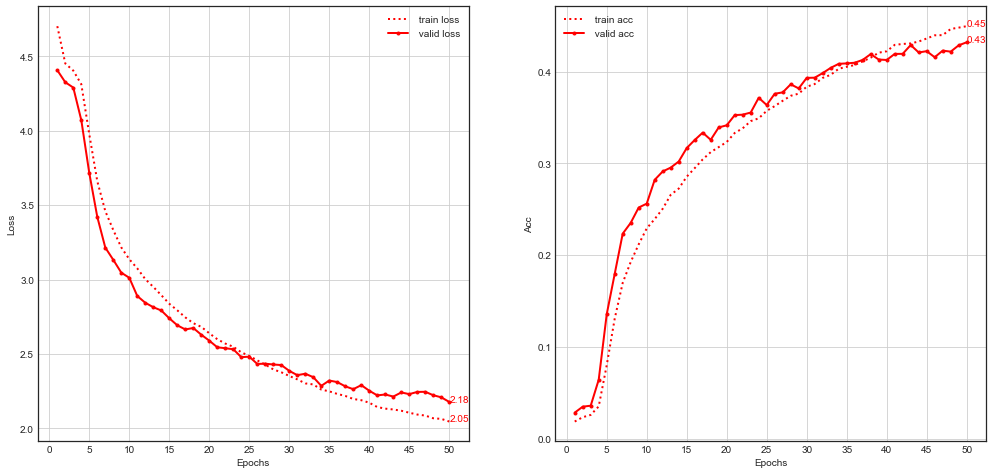

In [24]:
from Myfunc import show_lcurve
show_lcurve([history], [""], x_itv=5, lw=2, size=(17,8))